# Notebook for studying "STUMPY Basics" in Tutorials.

#### [References]
- STUMPY Basics
 - https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html
    
- STUMPY documentation:  
 - https://stumpy.readthedocs.io/en/latest/  

- The Matrix Profile
 - https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html

- GitHub repository of stumpy
 - https://github.com/TDAmeritrade/stumpy

---
## z-normalized Euclidean distanceについて
参考(Youtube)：[Time Series data Mining Using the Matrix Profile part 2](https://www.youtube.com/watch?v=LnQneYvg84M&t=374s)

以下の2つの時系列データ $\boldsymbol{x}$, $\boldsymbol{y} \in \mathbb{R}^{n}$ に対するz-normalized Euclidean distanceを考える。

$$
    \boldsymbol{x} = x_{1}, x_{2}, \cdots , x_{n} \\
    \boldsymbol{y} = y_{1}, y_{2}, \cdots , y_{n} \\
$$
に対して、z-normalized Euclidean distance $d:\mathbb{R}^{n} \times \mathbb{R}^{n} \rightarrow \mathbb{R}_{\geq 0}$ を以下で定義する。
$$
    d(\boldsymbol{x}, \boldsymbol{y}) := \sqrt(\sum_{i=1}^{n} (\hat{x}_{i} - \hat{y}_{i})^2)
$$
ただし、ここで $\hat{x}_{i}$ および $\hat{y}_{i}$ は

$$
    \hat{x}_{i} = \frac{x_{i}-\mu_{x}}{\sigma_{x}} \\
    \hat{y}_{i} = \frac{y_{i}-\mu_{x}}{\sigma_{y}} \\
$$
であるとする。

---
# Steamgen Dataset
## Find Motifs using STUMP

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

# matplotlibで使われるデフォルト値を変更する。
plt.rcParams["figure.figsize"] = [25, 3]  # width, height
plt.rcParams['xtick.direction'] = 'out'

今回利用する`streamgen dataset`というデータセットは発電所の蒸気発生器を模倣するシミュレータで生成されたデータである。  
このデータの特徴は、kg/s単位の出力蒸気流量遠隔測定であり、データは3秒ごとに「サンプリング」され、9600点のデータ点数がある。  
ここでは、特徴量`steam flow`を可視化する。

In [2]:
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
print(steam_df.shape)
steam_df.head()

(9600, 4)


,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


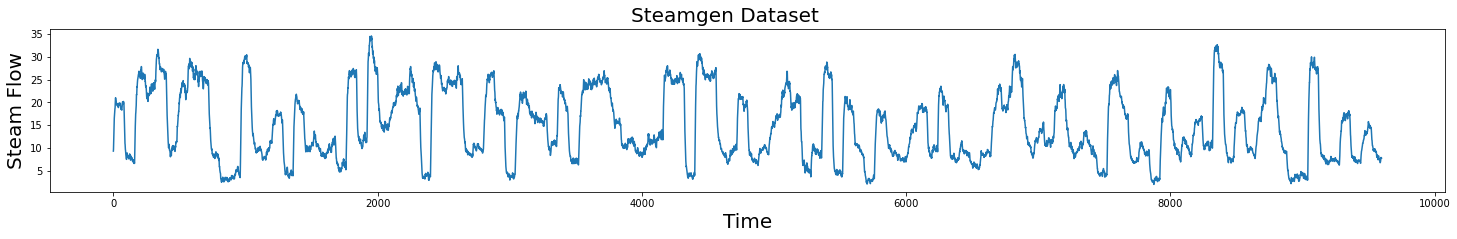

In [3]:
plt.suptitle('Steamgen Dataset', fontsize='20')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Steam Flow', fontsize='20')
plt.plot(steam_df['steam flow'].values)
plt.show()

特徴量`steam flow`の中の類似したパターンを目の子で見つけるのは難しいが、実は下の2段組の図において<font color="orange">オレンジ色</font>部分と<font color="green">緑色</font>部分は類似パターンとなっている。  
グレーにハッチされた部分を重ね合わせると、2つのsubsequenceが類似しているのがよくわかる。

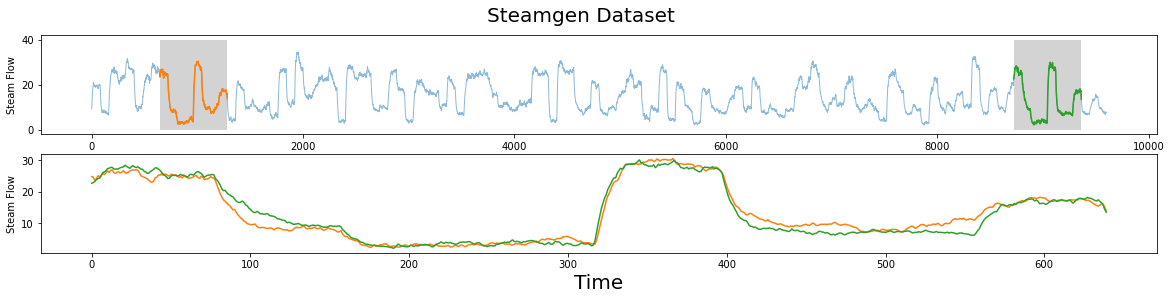

In [4]:
m = 640
fig, axs = plt.subplots(2, figsize=(20, 4))
plt.suptitle('Steamgen Dataset', fontsize='20')
axs[0].set_ylabel("Steam Flow", fontsize='10')
axs[0].plot(steam_df['steam flow'], alpha=0.5, linewidth=1)
axs[0].plot(steam_df['steam flow'].iloc[643:643+m])
axs[0].plot(steam_df['steam flow'].iloc[8724:8724+m])
rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("Steam Flow", fontsize='10')
axs[1].plot(steam_df['steam flow'].values[643:643+m], color='C1')
axs[1].plot(steam_df['steam flow'].values[8724:8724+m], color='C2')
plt.show()

Matrix Profileを用いれば、このようなmotiefを素早く見つけることができ、また時系列内の全てのsubsequenceに対して、その'最近接'を識別できる。  
以下では、実際にMatrix Profileを用いて類似motiefを探す方法を示す。








In [5]:
m = 640
mp = stumpy.stump(steam_df['steam flow'], m)

`stump`関数は(主に)以下の2つの引数を取る。（正確には[STUMPY API](https://stumpy.readthedocs.io/en/latest/api.html#stumpy.stump)を参照）

1. 第1引数： 時系列データ
2. 第2引数： ウィンドウサイズ, `m`

また、`stump`関数はnumpyu行列(ndarray)を返し、それぞれの列は以下のとおり。
1. 第1列目： matrix profile
2. 第2列目： matrix profileのそれぞれの要素に対し、その要素が選ばれる行における、その最小要素のindex（日本語がﾍﾝ）
3. 第3列目： <font color = 'red'>left matrix profile(?) のindex</font>
4. 第4列目： <font color = 'red'>right matrix profile(?) のindex</font>

今回は`m = 640`としているが、ウィンドウサイズは一般的にはドメイン知識を用いて決める。今の場合、`m = 640`と言うのは約30分間程度のデータになっている。（このデータのサンプリング周期は3秒間であった。)  
`stump`関数の出力は上で示したとおり、1列目はmatrix profile、2列目はmatrix profileのindexとなる。類似motifのindexの位置を見つけるためには、matrix profileの最小値とその(matrix profileの要素としての)indexを見つける必要がある。







In [6]:
motif_idx = np.argsort(mp[:, 0])[0]
print(f"The motif is located at index {motif_idx}")

The motif is located at index 643


`motif_idx`はmatrix profileの中の最小値がいる位置(index)を表している。`stump`関数の戻り値ndarrayの第2列目の値を見ることにより、`motif_idx`の位置から始まる長さ`m`分の波形の類似波形の先頭位置がわかる。

In [7]:
nearest_neighbor_idx = mp[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The nearest neighbor is located at index 8724


対称性の確認について

In [8]:
print(mp[nearest_neighbor_idx, 1]) # この値はmotif_idxとなるはず

643


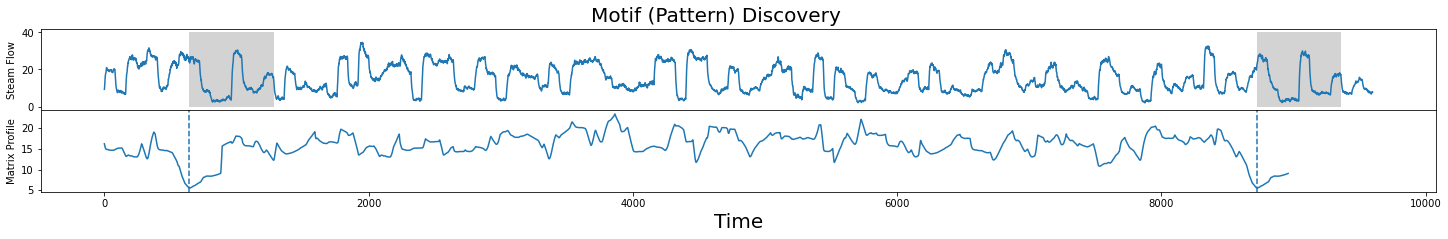

In [9]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='20')

axs[0].plot(steam_df['steam flow'].values)
axs[0].set_ylabel('Steam Flow', fontsize='10')
rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='10')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

---
## Find Potential Anomalies(Discords) using STUMP

先程は、Matrix Profileの最小値に着目することによりMotifを見つけることができた。では、Matrix Profileの最大値に着目すると何が言えるか？  
Matrix Profile内の最大値を持つindexは、以下のようになる。

In [10]:
discord_idx = np.argsort(mp[:, 0])[-1]

print(f"The discord is located at index {discord_idx}")

The discord is located at index 3864


`discord_idx`の位置でのMatrix Profileの値は、以下のようになる。

In [11]:
nearest_neighbor_distance = mp[discord_idx, 0]

print(f"The nearest neighbor subsequence to this discord is {nearest_neighbor_distance} units away")

The nearest neighbor subsequence to this discord is 23.476168367301987 units away


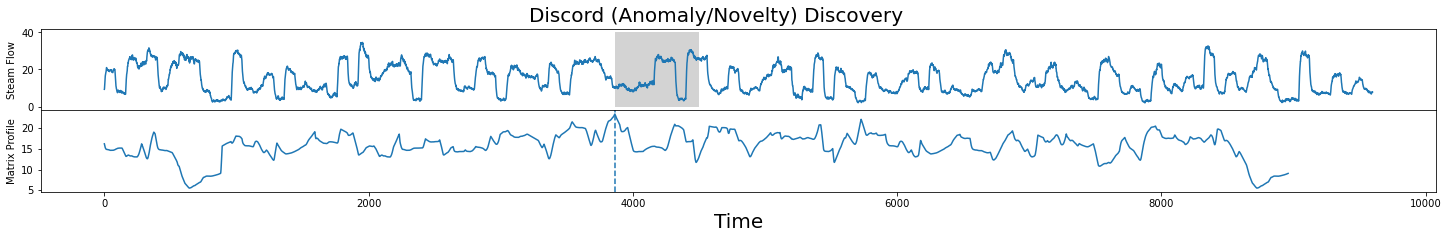

In [12]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='20')

axs[0].plot(steam_df['steam flow'].values)
axs[0].set_ylabel('Steam Flow', fontsize='10')
rect = Rectangle((discord_idx, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='10')
axs[1].axvline(x=discord_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

上のグラフの編みがけ部分のような、Matrix Profileの最大値から始まるsequenceは`discord`や`novelty`、`potential anomaly`などと呼ばれる。

---
# NYC Taxi Passengers Dataset

In [13]:
taxi_df = pd.read_csv("https://zenodo.org/record/4276428/files/STUMPY_Basics_Taxi.csv?download=1")
taxi_df['value'] = taxi_df['value'].astype(np.float64)
taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'])
taxi_df.head()

,timestamp,value
0,2014-10-01 00:00:00,12751.0
1,2014-10-01 00:30:00,8767.0
2,2014-10-01 01:00:00,7005.0
3,2014-10-01 01:30:00,5257.0
4,2014-10-01 02:00:00,4189.0


今回利用する`NYC Taxi Passengers Dataset` はNYCの2014年の秋の75日間における、タクシー利用者数の30分間平均を表す。

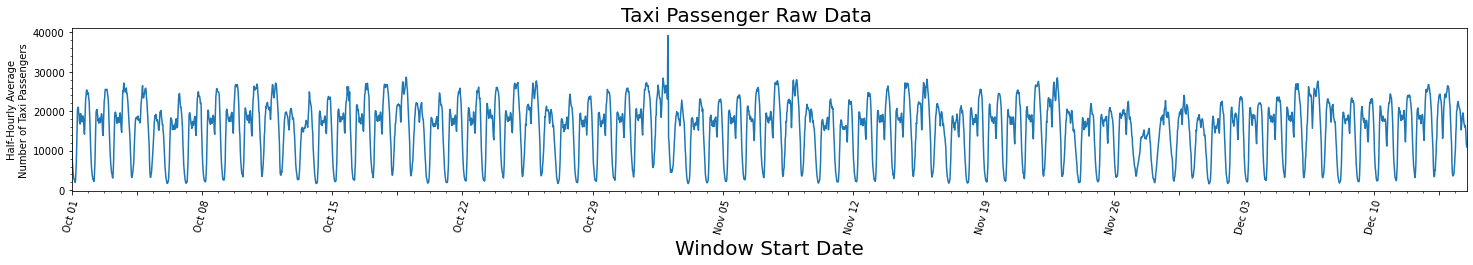

In [14]:
# This code is going to be utilized to control the axis labeling of the plots
DAY_MULTIPLIER = 7  # Specify for the amount of days you want between each labeled x-axis tick

x_axis_labels = taxi_df[(taxi_df.timestamp.dt.hour==0)]['timestamp'].dt.strftime('%b %d').values[::DAY_MULTIPLIER]
x_axis_labels[1::2] = " "
x_axis_labels, DAY_MULTIPLIER

plt.suptitle('Taxi Passenger Raw Data', fontsize='20')
plt.xlabel('Window Start Date', fontsize ='20')
plt.ylabel('Half-Hourly Average\nNumber of Taxi Passengers', fontsize='10')
plt.plot(taxi_df['value'])

plt.xticks(np.arange(0, taxi_df['value'].shape[0], (48*DAY_MULTIPLIER)/2), x_axis_labels)
plt.xticks(rotation=75)
plt.minorticks_on()
plt.margins(x=0)
plt.show()

このデータを見ると、1日間単位や及び7日間単位で周期性があるように見える。これはおそらく、夜間よりも昼間の利用の方が多いから1日間単位の周期性が見えるのであろうということと、  
ほとんどの週でタクシー利用者の行動パターンが似てるから7日間単位の周期性が現れるのであろうという推測が出来る。また、10月の終盤あたりで外れ値があることはすぐにわかるが、  
それ以外についての情報については、この図を見ているだけでは分からない。  
  
このデータに対して、Matrix Profileを計算してみよう。

---
## Understanding the Matrix Profile

In [15]:
m = 48
mp = stumpy.stump(taxi_df['value'], m=m)

例によってウィンドウサイズ`m`の値はドメイン側で決める。今回の場合はデータが30分間隔になっているということを踏まえ、ちょうど1日のデータ点数である`m = 48`と設定した。  
(実は後ほどに、この`m`の値を変更しても`stump`関数はロバストであるということを示す。)  

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


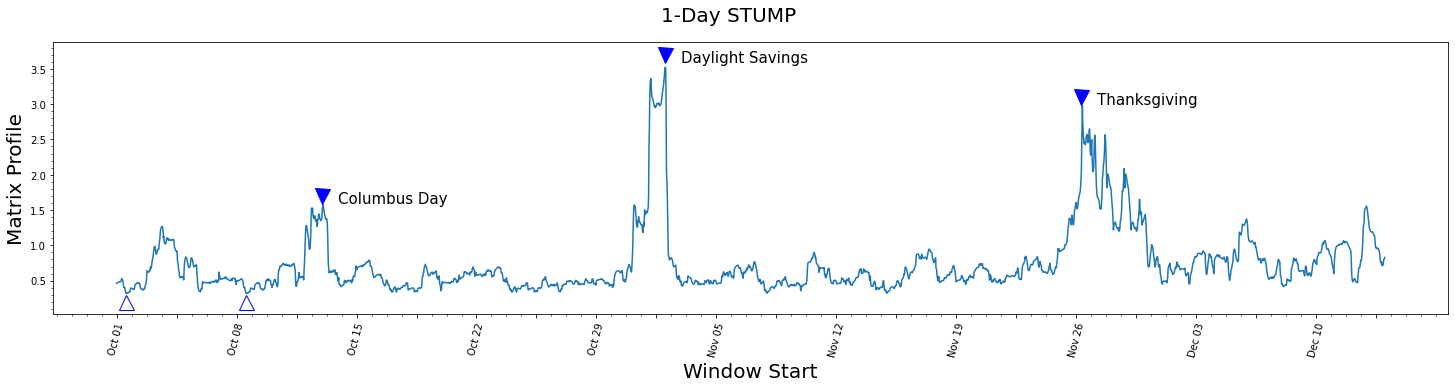

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))

fig.suptitle('1-Day STUMP', fontsize='20')
ax.set_xlabel('Window Start', fontsize ='20')
ax.set_ylabel('Matrix Profile', fontsize='20')
ax.plot(mp[:, 0])

ax.plot(575, 1.7, marker="v", markersize=15, color='b')
ax.text(620, 1.6, 'Columbus Day', color="black", fontsize=15)
ax.plot(1535, 3.7, marker="v", markersize=15, color='b')
ax.text(1580, 3.6, 'Daylight Savings', color="black", fontsize=15)
ax.plot(2700, 3.1, marker="v", markersize=15, color='b')
ax.text(2745, 3.0, 'Thanksgiving', color="black", fontsize=15)
ax.plot(27, .2, marker="^", markersize=15, color='b', fillstyle='none') # 元のTutorialでは30となっていた。
ax.plot(363, .2, marker="^", markersize=15, color='b', fillstyle='none')
ax.set_xticks(np.arange(0, 3553, (m*DAY_MULTIPLIER)/2))
ax.set_xticklabels(x_axis_labels, rotation=75)
ax.minorticks_on()
fig.show()

Matrix Profileの考察について
- 最小値について
    - 上図の2箇所の白抜き三角形は、Matrix Profileの最小値のindexから始まるmotifと、そのnearest neighborのペアを示している。  
      興味深いことに、このペアはちょうど7日離れている。よって、7日の周期性があるかもしれないということを示している。
- 最大値について
    - 上図の3箇所の黒塗り三角形は、Matrix Profileの最大値のtop 3を表している。実はこの3箇所はそれぞれ、コロンブスの日、サマータイム、感謝祭のタイミングに対応している。

また、上図ではMatrix Profileの最小値 or 最大値についてそのindexを既知としてグラフを書いたが、このindexをmpから求めてみる。

In [17]:
# Matrix Profileの最小値について
print(np.argsort(mp[:, 0]))

min_idx_0 = np.argsort(mp[:, 0])[0]
min_idx_1 = np.argsort(mp[:, 0])[1]
print('min_idx_0 =', min_idx_0)
print('min_idx_1 =', min_idx_1)
print('min_0 =', mp[min_idx_0, 0])
print('min_1 =', mp[min_idx_1, 0])

[  27  363  368 ... 1538 1536 1537]
min_idx_0 = 27
min_idx_1 = 363
min_0 = 0.3196090265489718
min_1 = 0.3196090265489718


In [18]:
nearest_neighbor_idx_0 = mp[min_idx_0, 1]
nearest_neighbor_idx_1 = mp[min_idx_1, 1]
print('nearest_neighbor_idx_0 =', nearest_neighbor_idx_0)
print('nearest_neighbor_idx_1 =', nearest_neighbor_idx_1)

nearest_neighbor_idx_0 = 363
nearest_neighbor_idx_1 = 27


In [19]:
# Matrix Profileの最大値top3について
max_idx_0 = np.argsort(mp[:, 0])[-1]
max_idx_1 = np.argsort(mp[:, 0])[-2]
max_idx_2 = np.argsort(mp[:, 0])[-3]
print('max_idx_0 =', max_idx_0)
print('max_idx_1 =', max_idx_1)
print('max_idx_2 =', max_idx_2)

max_idx_0 = 1537
max_idx_1 = 1536
max_idx_2 = 1538


厳密にtop3だと隣接した点が出てしまうので、結局Matrix Profileのグラフを目で見た際のピークを探すことになる？  
あるいは、scipy.signal.find_peaksなどを使えばcatchできる？

---
## Different Window Sizes
上で述べたように、`stump`関数はウィンドウサイズ`m`に対してロバストであるべき。以下の考察で`m`の値を変えてもロバストであることを見る。  
(`m`の値はMatrix Profileに対してほとんど影響を与えないことを示す。)

In [20]:
days_dict ={
  "Half-Day": 24,
  "1-Day": 48,
  "2-Days": 96,
  "5-Days": 240,
  "7-Days": 336,
}

days_df = pd.DataFrame.from_dict(days_dict, orient='index', columns=['m'])
days_df.head()

,m
Half-Day,24
1-Day,48
2-Days,96
5-Days,240
7-Days,336


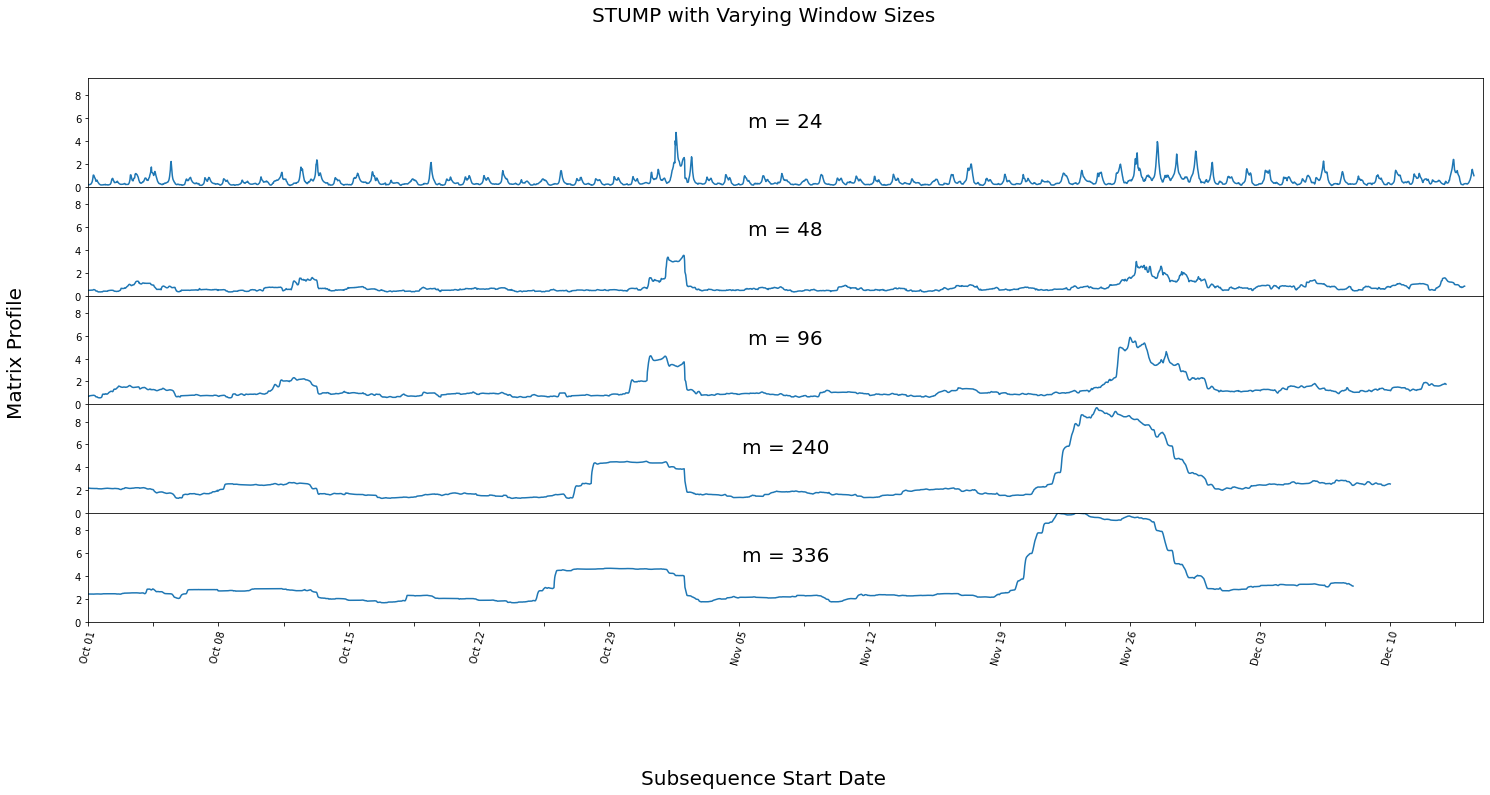

In [21]:
fig, axs = plt.subplots(5, sharex=True, gridspec_kw={'hspace': 0}, figsize=(25, 10))
fig.text(0.5, -0.1, 'Subsequence Start Date', ha='center', fontsize='20')
fig.text(0.08, 0.5, 'Matrix Profile', va='center', rotation='vertical', fontsize='20')
for i, varying_m in enumerate(days_df['m'].values):
    mp = stumpy.stump(taxi_df['value'], varying_m)
    axs[i].plot(mp[:, 0])
    axs[i].set_ylim(0,9.5)
    axs[i].set_xlim(0,3600)
    title = f"m = {varying_m}"
    axs[i].set_title(title, fontsize=20, y=.5)
plt.xticks(np.arange(0, taxi_df.shape[0], (48*DAY_MULTIPLIER)/2), x_axis_labels)
plt.xticks(rotation=75)
plt.suptitle('STUMP with Varying Window Sizes', fontsize='20')
plt.show()

以上の考察により、ウィンドウサイズ`m`を変えても、ピークは立ったまま(?)であることが分かる。しかしながら、ピーク以外の値は全て互いに収束しているように見えるので、  
これが、`stump`を実行する前の`m`の候補値を根拠を持って決められるドメイン知識を持っていることが重要であることの理由となる。